In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
import torch.utils.data
import pickle
import numpy as np
import pandas as pd
import scipy.io as sio
import time
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
from keras import optimizers, Sequential
from keras.layers import LSTM, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

from numpy.random import seed
seed(1)
# from tensorflow import set_random_seed
# set_random_seed(2)
SEED = 123
DATA_SPLIT_PCT = 0.2

In [ ]:
# Hyper Parameters
N_EPOCHS = 200
BATCH_SIZE = 64 # how to choose batch_size? too big
LR = 1e-4 # learning rate
HIDDEN_SIZE = 125
INPUT_SIZE = 125
OUTPUT_SIZE = 1
NUM_LAYERS = 4
WINDOW_SIZE = 128

np.random.seed(123)

In [ ]:
dataset_file = "s01.mat"
print("Processing",dataset_file,"..........")
data_file_in = sio.loadmat(dataset_file)
data_in = data_file_in["data"].transpose(0,2,1) #tuple # 40*40*8064
window_size = WINDOW_SIZE
# 0 valence, 1 arousal, 2 dominance, 3 liking
label = 1
label_in= data_file_in["labels"][:,label]>5
label_inter = np.empty([0])
data_inter = np.empty([0, window_size, 32])
trials = data_in.shape[0] # trials = 40

Processing s01.mat ..........


In [ ]:
# get the data and the label
def windows(data, size):
    start = 0
    while((start+size) < data.shape[0]):
        yield int(start), int(start + size)
        start += size
        
def segment_signal(data,label,label_index,window_size):
    for (start, end) in windows(data, window_size):
        if((len(data[start:end]) == window_size)):
            if(start == 0):
                segments = data[start:end]
                segments = np.vstack([segments, data[start:end]])
                
                labels = np.array(label[label_index])
                labels = np.append(labels, np.array(label[label_index]))
            else:
                segments = np.vstack([segments, data[start:end]])
                labels = np.append(labels, np.array(label[label_index]))
    return segments, labels

In [ ]:
for trial in range(0, trials):
    base_signal = (data_in[trial, 0:128, 0:32]+data_in[trial,128:256,0:32]+data_in[trial,256:384,0:32])/3
    data = data_in[trial,384:8064,0:32]
    # compute the deviation
    for i in range(0, 60):
        data[i*128:(i+1)*128,0:32]=data[i*128:(i+1)*128,0:32]-base_signal
    label_index = trial
    data, label = segment_signal(data,label_in,label_index,window_size)
    # data reshape
    data = data.reshape(int(data.shape[0]/window_size), window_size, 32) # features=32
    # append new data and label
    data_inter = np.vstack([data_inter, data])
    label_inter = np.append(label_inter, label)

In [ ]:
# shuffle data
index = np.array(range(0, len(label_inter)))
np.random.shuffle(index)
shuffled_data = data_inter[index]
shuffled_label = label_inter[index]

In [ ]:
X = shuffled_data
y = shuffled_label

In [ ]:
X_train, X_test = train_test_split(X, test_size=DATA_SPLIT_PCT, random_state=SEED)
X_train, X_valid = train_test_split(X_train, test_size=DATA_SPLIT_PCT, random_state=SEED)

y_train, y_test = train_test_split(y, test_size=DATA_SPLIT_PCT, random_state=SEED)
y_train, y_valid = train_test_split(y_train, test_size=DATA_SPLIT_PCT, random_state=SEED)

In [ ]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
    return X

In [ ]:
# Initialize a scaler using the training data.
scaler = StandardScaler().fit(flatten(X_train))

# scaler is the fitted transform object
# use scale func to stanbdardize X_train
X_train_scaled = scale(X_train, scaler)
X_valid_scaled = scale(X_valid, scaler)
X_test_scaled = scale(X_test, scaler)

In [ ]:
samples = shuffled_data.shape[0] # 2400
timesteps = shuffled_data.shape[1] # 128
features = shuffled_data.shape[2] # 32

In [ ]:
model = Sequential()
# encoder
model.add(LSTM(100, activation='tanh',
               input_shape=(timesteps, features), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(80, activation='tanh', return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(20, activation='tanh', return_sequences=True))
# decoder
model.add(LSTM(100, activation='tanh', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(32, activation='tanh', return_sequences=True))
model.add(Dropout(0.3))
model.add(TimeDistributed(Dense(features, activation='sigmoid'))) # two trials: with & without SHOULD have
model.add(Dropout(0.1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 128, 100)          53200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128, 100)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 128, 80)           57920     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128, 80)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 128, 20)           8080      
_________________________________________________________________
lstm_7 (LSTM)                (None, 128, 100)          48400     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128, 100)         

In [ ]:
# train the autoencoder
adam = optimizers.Adam(LR)
# model.compile(metrics=['accuracy'], loss='mse', optimizer=adam)

cp = ModelCheckpoint(filepath="/EEGResearch/lstm_autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)
tb = TensorBoard(log_dir='/EEGResearch/logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)
history = model.fit(X_train, X_train, 
                                                epochs=N_EPOCHS, 
                                                batch_size=BATCH_SIZE, 
                                                validation_data=(X_valid, X_valid),
                                                verbose=2).history
change = model.predict(X_train_scaled)
print(change.shape)

Epoch 1/200
24/24 - 2s - loss: 1.2329 - val_loss: 1.1164
Epoch 2/200
24/24 - 1s - loss: 1.1100 - val_loss: 1.0562
Epoch 3/200
24/24 - 1s - loss: 1.0666 - val_loss: 1.0377
Epoch 4/200
24/24 - 1s - loss: 1.0504 - val_loss: 1.0309
Epoch 5/200
24/24 - 1s - loss: 1.0433 - val_loss: 1.0278
Epoch 6/200
24/24 - 1s - loss: 1.0397 - val_loss: 1.0261
Epoch 7/200
24/24 - 1s - loss: 1.0375 - val_loss: 1.0250
Epoch 8/200
24/24 - 1s - loss: 1.0360 - val_loss: 1.0242
Epoch 9/200
24/24 - 1s - loss: 1.0350 - val_loss: 1.0236
Epoch 10/200
24/24 - 1s - loss: 1.0343 - val_loss: 1.0232
Epoch 11/200
24/24 - 1s - loss: 1.0336 - val_loss: 1.0229
Epoch 12/200
24/24 - 1s - loss: 1.0332 - val_loss: 1.0226
Epoch 13/200
24/24 - 1s - loss: 1.0328 - val_loss: 1.0224
Epoch 14/200
24/24 - 1s - loss: 1.0325 - val_loss: 1.0222
Epoch 15/200
24/24 - 1s - loss: 1.0324 - val_loss: 1.0221
Epoch 16/200
24/24 - 1s - loss: 1.0321 - val_loss: 1.0220
Epoch 17/200
24/24 - 1s - loss: 1.0319 - val_loss: 1.0219
Epoch 18/200
24/24 - 1s

In [ ]:
# train the autoencoder
adam = optimizers.Adam(LR)
# model.compile(metrics=['accuracy'], loss='mse', optimizer=adam)

cp = ModelCheckpoint(filepath="/EEGResearch/lstm_autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)
tb = TensorBoard(log_dir='/EEGResearch/logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)
history = model.fit(X_train, X_train, 
                                                epochs=N_EPOCHS, 
                                                batch_size=BATCH_SIZE, 
                                                validation_data=(X_valid, X_valid),
                                                verbose=2).history
change = model.predict(X_train_scaled)
print(change.shape)

Epoch 1/200
24/24 - 2s - loss: 1.2379 - val_loss: 1.1273
Epoch 2/200
24/24 - 1s - loss: 1.1171 - val_loss: 1.0504
Epoch 3/200
24/24 - 1s - loss: 1.0617 - val_loss: 1.0217
Epoch 4/200
24/24 - 1s - loss: 1.0373 - val_loss: 1.0057
Epoch 5/200
24/24 - 1s - loss: 1.0218 - val_loss: 0.9918
Epoch 6/200
24/24 - 1s - loss: 1.0078 - val_loss: 0.9750
Epoch 7/200
24/24 - 1s - loss: 0.9874 - val_loss: 0.9448
Epoch 8/200
24/24 - 1s - loss: 0.9624 - val_loss: 0.9206
Epoch 9/200
24/24 - 1s - loss: 0.9438 - val_loss: 0.9018
Epoch 10/200
24/24 - 1s - loss: 0.9288 - val_loss: 0.8878
Epoch 11/200
24/24 - 1s - loss: 0.9182 - val_loss: 0.8770
Epoch 12/200
24/24 - 1s - loss: 0.9090 - val_loss: 0.8675
Epoch 13/200
24/24 - 1s - loss: 0.9003 - val_loss: 0.8576
Epoch 14/200
24/24 - 1s - loss: 0.8911 - val_loss: 0.8463
Epoch 15/200
24/24 - 1s - loss: 0.8810 - val_loss: 0.8354
Epoch 16/200
24/24 - 1s - loss: 0.8720 - val_loss: 0.8256
Epoch 17/200
24/24 - 1s - loss: 0.8639 - val_loss: 0.8168
Epoch 18/200
24/24 - 1s

In [ ]:
LR = 1e-3

In [ ]:
# train the autoencoder
adam = optimizers.Adam(LR)
# model.compile(metrics=['accuracy'], loss='mse', optimizer=adam)

cp = ModelCheckpoint(filepath="/EEGResearch/lstm_autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)
tb = TensorBoard(log_dir='/EEGResearch/logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)
history = model.fit(X_train, X_train, 
                                                epochs=N_EPOCHS, 
                                                batch_size=BATCH_SIZE, 
                                                validation_data=(X_valid, X_valid),
                                                verbose=2).history
change = model.predict(X_train_scaled)
print(change.shape)

Epoch 1/200
24/24 - 1s - loss: 0.7170 - val_loss: 0.6567
Epoch 2/200
24/24 - 1s - loss: 0.7167 - val_loss: 0.6565
Epoch 3/200
24/24 - 1s - loss: 0.7167 - val_loss: 0.6564
Epoch 4/200
24/24 - 1s - loss: 0.7165 - val_loss: 0.6562
Epoch 5/200
24/24 - 1s - loss: 0.7163 - val_loss: 0.6558
Epoch 6/200
24/24 - 1s - loss: 0.7162 - val_loss: 0.6558
Epoch 7/200
24/24 - 1s - loss: 0.7162 - val_loss: 0.6556
Epoch 8/200
24/24 - 1s - loss: 0.7158 - val_loss: 0.6555
Epoch 9/200
24/24 - 1s - loss: 0.7157 - val_loss: 0.6553
Epoch 10/200
24/24 - 1s - loss: 0.7155 - val_loss: 0.6552
Epoch 11/200
24/24 - 1s - loss: 0.7154 - val_loss: 0.6550
Epoch 12/200
24/24 - 1s - loss: 0.7156 - val_loss: 0.6548
Epoch 13/200
24/24 - 1s - loss: 0.7153 - val_loss: 0.6548
Epoch 14/200
24/24 - 1s - loss: 0.7149 - val_loss: 0.6546
Epoch 15/200
24/24 - 1s - loss: 0.7149 - val_loss: 0.6543
Epoch 16/200
24/24 - 1s - loss: 0.7146 - val_loss: 0.6544
Epoch 17/200
24/24 - 1s - loss: 0.7147 - val_loss: 0.6540
Epoch 18/200
24/24 - 1s

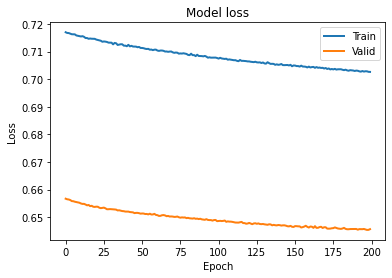

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# change in loss
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

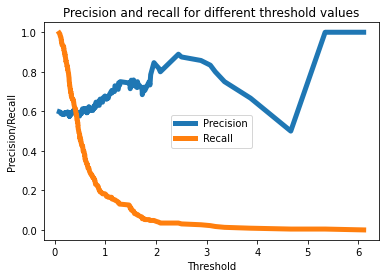

In [ ]:
# use the validation set to identify the threshold here, should I use test data?
valid_x_predictions = model.predict(X_valid_scaled)
mse = np.mean(np.power(flatten(X_valid_scaled) - flatten(valid_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_valid.tolist()})

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

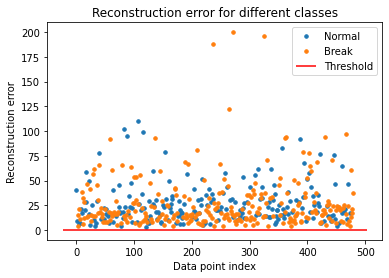

In [ ]:
test_x_predictions = model.predict(X_test_scaled)
mse = np.mean(np.power(flatten(X_test_scaled) - flatten(test_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test.tolist()})

threshold_fixed = 0.3
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()
# threshold = 0.3, 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


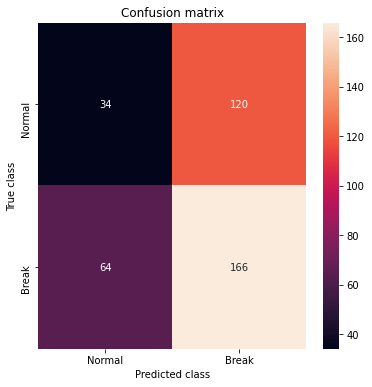

In [ ]:
# test accuracy
import seaborn as sns
threshold_fixed = 0.3
LABELS = ["Normal","Break"]
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

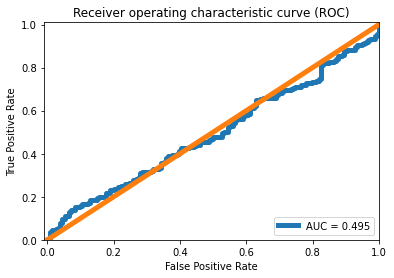

In [ ]:
# ROC curve and AUC
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
# AUC is aproximately 50%, not good enough

In [ ]:
model = Sequential()
# encoder
model.add(LSTM(100, activation='relu',
               input_shape=(timesteps, features), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(80, activation='relu', return_sequences=True))
model.add(Dropout(0.5))
# decoder
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(TimeDistributed(Dense(features, activation='sigmoid'))) # two trials: with & without SHOULD have
model.add(Dropout(0.1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128, 100)          53200     
_________________________________________________________________
dropout (Dropout)            (None, 128, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128, 80)           57920     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 80)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128, 100)          72400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128, 100)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128, 32)          

In [ ]:
# train the autoencoder
adam = optimizers.Adam(LR)
# model.compile(metrics=['accuracy'], loss='mse', optimizer=adam)

cp = ModelCheckpoint(filepath="/EEGResearch/lstm_autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)
tb = TensorBoard(log_dir='/EEGResearch/logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)
history = model.fit(X_train, X_train, 
                                                epochs=N_EPOCHS, 
                                                batch_size=BATCH_SIZE, 
                                                validation_data=(X_valid, X_valid),
                                                verbose=2).history
change = model.predict(X_train_scaled)

Epoch 1/200
24/24 - 10s - loss: 1.2748 - val_loss: 1.2365
Epoch 2/200
24/24 - 9s - loss: 1.2509 - val_loss: 1.2202
Epoch 3/200
24/24 - 9s - loss: 1.2302 - val_loss: 1.2040
Epoch 4/200
24/24 - 9s - loss: 1.2078 - val_loss: 1.1820
Epoch 5/200
24/24 - 9s - loss: 1.1838 - val_loss: 1.1636
Epoch 6/200
24/24 - 10s - loss: 1.1641 - val_loss: 1.1476
Epoch 7/200
24/24 - 10s - loss: 1.1465 - val_loss: 1.1327
Epoch 8/200
24/24 - 10s - loss: 1.1310 - val_loss: 1.1184
Epoch 9/200
24/24 - 10s - loss: 1.1160 - val_loss: 1.1048
Epoch 10/200
24/24 - 10s - loss: 1.1017 - val_loss: 1.0903
Epoch 11/200
24/24 - 10s - loss: 1.0878 - val_loss: 1.0748
Epoch 12/200
24/24 - 10s - loss: 1.0715 - val_loss: 1.0495
Epoch 13/200
24/24 - 10s - loss: 1.0555 - val_loss: 1.0386
Epoch 14/200
24/24 - 10s - loss: 1.0523 - val_loss: 1.0367
Epoch 15/200
24/24 - 9s - loss: 1.0502 - val_loss: 1.0356
Epoch 16/200
24/24 - 9s - loss: 1.0483 - val_loss: 1.0347
Epoch 17/200
24/24 - 10s - loss: 1.0509 - val_loss: 1.0583
Epoch 18/200

KeyboardInterrupt: ignored

In [ ]:
psd feature (welch network) code to extract
entropy feature
2D #CNN

connectivity feature
extracting
as input instead original data
separatly or conbination

classifier
paraller model

